## Imports

In [6]:
#matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import numpy as np
import os
import nltk
from PIL import Image
from cache import cache
from tensorflow.python import keras

/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [7]:
from keras import backend as K
from keras import layers, models, optimizers, callbacks
from keras.models import Model
from keras.layers import Input, Dense, GRU, Embedding, Conv2D, Layer, concatenate
from keras.applications import VGG16
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications import ResNet50
from keras.applications import InceptionV3

Using TensorFlow backend.


In [8]:
tf.device("/device:GPU:0")
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

AttributeError: module 'tensorflow' has no attribute 'Session'

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
sess = tf.Session(config=config)
tf.device(tf.DeviceSpec(device_type="GPU", device_index="0"))

In [ ]:
tf.__version__

In [ ]:
import coco

In [ ]:
coco.download

In [ ]:
_, filenames_train, captions_train =coco.load_records(train=True)

In [ ]:
# _, filenames_test, captions_test = coco.load_records(train=False)
_, filenames_val, captions_val = coco.load_records(train=False)

In [ ]:
num_images_train = len(filenames_train)
print("number of train images : ",num_images_train)
num_caption_train = len(captions_train)
print("number of train captions : ",num_caption_train)
num_images_val = len(filenames_val)
print("number of validation images : ",num_images_val)
num_caption_val = len(captions_val)
print("number of validation captions : ",num_caption_val)

In [ ]:
filenames_test=filenames_val
captions_test=captions_val

In [ ]:
num_images_val = len(filenames_val)
num_images_val

In [ ]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [ ]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
#     for caption in captions:
#         print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

In [ ]:
show_image(idx=0, train=True)

In [ ]:
image_model =VGG16(include_top=True, weights='imagenet')

In [ ]:
# use vgg16
image_model.summary()

In [ ]:
import h5py
import pickle
from keras import  optimizers, callbacks
import argparse
from tensorflow.python.keras.utils import to_categorical
from utils3 import combine_images,plot_log
from capsule_layers import CapsuleLayer, PrimaryCap, Length, Mask

K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MSCOCO.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = Input(shape=input_shape)

    # Layers 1-3: Just some conventional Conv2D layers
    conv1 = Conv2D(filters=96, kernel_size=13, strides=4, padding='valid', activation='relu', name='conv1')(x)
    conv2 = Conv2D(filters=96, kernel_size=5, strides=2, padding='valid', activation='relu', name='conv2')(conv1)
    conv3 = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv3')(conv2)


    # Layer 4: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primary_caps = PrimaryCap(conv3, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    category_caps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,name='category_caps')(primary_caps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(category_caps)

    # Decoder network.
    y = Input(shape=(n_class,))
    masked_by_y = Mask()([category_caps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(category_caps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(Dense(1024, activation='relu'))
#     decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
#     decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))
    
    # Models for training and evaluation (prediction)
    train_model = Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = Input(shape=(n_class, 16))
    noised_category_caps = layers.Add()([category_caps, noise])
    masked_noised_y = Mask()([noised_category_caps, y])
    manipulate_model =Model([x, y, noise], decoder(masked_noised_y))

    return train_model, eval_model, manipulate_model

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args['save_dir'] + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args['save_dir'] + '/tensorboard-logs',
                               batch_size=args['batch_size'], histogram_freq=int(args['debug']))
    checkpoint = callbacks.ModelCheckpoint(args['save_dir'] + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args['lr'] * (args['lr_decay'] ** epoch))
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    # compile the model

    model.compile(optimizer=optimizers.Adam(lr=args['lr']),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args['lam_recon']],
                  metrics={'capsnet': 'accuracy'})

    
    # Training without data augmentation:
    model.fit(
        [x_train, y_train],
        [y_train, x_train],
        batch_size=args['batch_size'],
        epochs=args['epochs'],
        validation_data=[[x_test, y_test], [y_test, x_test]],
        callbacks=[log, tb, checkpoint, lr_decay, early_stop]
    )

def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-' * 30 + 'Begin: test' + '-' * 30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50], x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()


def manipulate_latent(model, data, args):
    print('-' * 30 + 'Begin: manipulate' + '-' * 30)
    x_test, y_test = data
    index = np.argmax(y_test, 1) == args.digit
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = x_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 80, 16])
    x_recons = []
    for dim in range(16):
        for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
            tmp = np.copy(noise)
            tmp[:, :, dim] = r
            x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)

    x_recons = np.concatenate(x_recons)

    img = combine_images(x_recons, height=16)
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + '/manipulate-%d.png' % args.digit)
    print('manipulated result saved to %s/manipulate-%d.png' % (args.save_dir, args.digit))
    print('-' * 30 + 'End: manipulate' + '-' * 30)



def load_coco(dataset_file, map_file):
    """
    Load preprocessed MSCOCO 2017 dataset
    """
    print('\nLoading dataset...')
    h5f = h5py.File(dataset_file, 'r')
    x = h5f['x'][:]
    y = h5f['y'][:]
    h5f.close()

    split = int(x.shape[0] * 0.8)  # 80% of data is assigned to the training set
    x_train, y_train = x[:split], y[:split]
    x_test, y_test = x[split:], y[split:]

    with open(map_file, 'rb') as mapping:
        category_id_map = pickle.load(mapping)
    id_category = category_id_map['id_category']
    print('Done.')

    return (x_train, y_train), (x_test, y_test), id_category


if __name__ == "__main__":

    # setting the hyper parameters
    parser = argparse.ArgumentParser(description="Capsule Network on MSCOCO 2017.")
    parser.add_argument('--epochs', default=1, type=int)
    parser.add_argument('--batch_size', default=100, type=int)
    parser.add_argument('--lr', default=0.001, type=float, help="Initial learning rate")
    parser.add_argument('--lr_decay', default=1, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser.add_argument('--lam_recon', default=0.392, type=float, help="The coefficient for the loss of decoder")
    parser.add_argument('-r', '--routings', default=3, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")  # num_routing should > 0
    parser.add_argument('--debug', action='store_true', help="Save weights by TensorBoard")
    parser.add_argument('--save_dir', default='./result')
    parser.add_argument(
        '--dataset_file', default=os.path.join(os.path.dirname(os.path.abspath('__file__')), 'dataset/capsnet_train_data.h5'),
        help='File having the preprocessed dataset')
    parser.add_argument('-t', '--testing', action='store_true',
                        help='Test the trained model on testing dataset')
    parser.add_argument('--digit', default=5, type=int,
                        help="Digit to manipulate")
    parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
    
    parser.add_argument(
        '--map_file', default=os.path.join(os.path.dirname(os.path.realpath('__file__')), 'dataset/coco_raw.pickle'),
        help='File having the id to category map'
    )
    args = parser.parse_known_args()[0]
    print(args)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    # load data
    (x_train, y_train), (x_test, y_test), id_category = load_coco(args.dataset_file, args.map_file)

    # define model
    model, eval_model, manipulate_model = CapsNet(
        input_shape=(224, 224, 3),
        n_class=y_train.shape[1],
        routings=args.routings
    )


    model.summary()

    # train or test
#     if args.weights is not None:  # init the model weights with provided one
#         model.load_weights(args.weights)
#     if not args.testing:

#         train(model=model, data=((x_train, y_train), (x_test, y_test)), args=vars(args))
#     else:  # as long as weights are given, will run testing
#         if args.weights is None:
#             print('No weights are provided. Will test using random initialized weights.')
#         manipulate_latent(manipulate_model, (x_test, y_test), args)
#         test(model=eval_model, data=(x_test, y_test), args=args)

In [ ]:
#     model, eval_model, manipulate_model = CapsNet(
#         input_shape=(224, 224, 3),
#         n_class=y_train.shape[1],
#         routings=args.routings
#     )


In [ ]:
label_layer = image_model.get_layer('predictions')
label_layer.output

In [ ]:
#use VGG16
transfer_layer = image_model.get_layer('fc2')

In [ ]:
print(eval_model.input)
print(image_model.input)
print(eval_model.output[1])
print(transfer_layer.output)

In [ ]:
tf.concat([eval_model.output[1],transfer_layer.output],1)

In [ ]:
capsule_model=models.Model(inputs=eval_model.input,outputs=eval_model.output[1])
capsule_model.output

In [ ]:
# from keras_applications.vgg16 import decode_predictions
# image_model.predict()
# # vgg16.decode_predictions(np.arange(1000), top=1000)

In [ ]:
transfer_layer.output

In [ ]:
# print (bottleneck_model.summary())
image_model_transfer = models.Model(inputs=image_model.input, outputs=image_model.get_layer('fc2').output)
# image_model_transfer= image_model
image_model_transfer.summary()

In [ ]:
# image_model_capsule = models.Model(inputs=[eval_model.input,image_model.input],outputs=[eval_model.output[1],transfer_layer.output])
# image_model_capsule.summary()

In [ ]:
# image_model_transfer =models.Model(inputs=image_model.input,outputs=transfer_layer.output)
# # image_model_transfer= image_model
# image_model_transfer.summary()


In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

In [ ]:
# img_size1 = K.int_shape(image_model_capsule.input[0])[1:3]
# img_size2 = K.int_shape(image_model_capsule.input[1])[1:3]
len(filenames_val)

In [ ]:
# transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size=5120

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            np.concatenate([image_model_transfer.predict(image_batch[0:current_batch_size]),capsule_model.predict(image_batch[0:current_batch_size])],1)
#             image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

In [ ]:
def process_images_label(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)
     

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    shape2 = (batch_size,) + (1000,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    shape2 = (num_images,1000)
    label_values = np.zeros(shape=shape2, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img


        label_value_batch = image_model.predict(image_batch[0:current_batch_size])

        label_values[start_index:end_index] =label_value_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return label_values


In [ ]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path1 = os.path.join(coco.data_dir,
                              "capsule_transfer_values_train_caps.pkl")
    cache_path2 = os.path.join(coco.data_dir, "label_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path1,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    label_values = cache(cache_path=cache_path2,
                            fn=process_images_label,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values,label_values

In [ ]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
#     cache_path = os.path.join(coco.data_dir, "capsule_transfer_values_val.pkl")
    cache_path1 = os.path.join(coco.data_dir, "capsule_transfer_values_val.pkl")
    cache_path2 = os.path.join(coco.data_dir, "label_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path1,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)
    label_values = cache(cache_path=cache_path2,
                            fn=process_images_label,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)
    

    return transfer_values,label_values

In [ ]:
# ***************if we dont want to run below cell and load saved value***************
# import os

# base_path = "/scratch/data/"
# filename = "capsule_transfer_values_train_caps.pkl"
# path_to_file = os.path.join(base_path, filename)
# filename2 = "capsule_transfer_values_val.pkl"
# path_to_file2 = os.path.join(base_path, filename2)

# filename3 = "label_values_train.pkl"
# path_to_file3 = os.path.join(base_path, filename3)
# filename4 = "label_values_val.pkl"
# path_to_file4 = os.path.join(base_path, filename4)


# transfer_values_train_caps =open(path_to_file)
# transfer_values_val_caps =open(path_to_file2)

# # label_train_caps =open(path_to_file3)
# label_val_caps =open(path_to_file4)


In [ ]:
# %%time
# import sys
# # transfer_values_train_caps = process_images_train()
# [transfer_values_train_caps,label_values] = process_images_train()
# print("dtype:", transfer_values_train_caps.dtype)
# print("shape:", transfer_values_train_caps.shape)
# %%time
import sys
# transfer_values_train_caps = process_images_train()
[transfer_values_train_caps,label_train_caps] = process_images_train()
print("dtype:", transfer_values_train_caps.dtype)
print("shape:", transfer_values_train_caps.shape)
print("dtype:", label_train_caps.dtype)
print("shape:", label_train_caps.shape)

In [ ]:
# %%time
# transfer_values_val_caps = process_images_val()
# print("dtype:", transfer_values_val_caps.dtype)
# print("shape:", transfer_values_val_caps.shape)
[transfer_values_val_caps,label_val_caps] = process_images_val()
print("dtype:", transfer_values_val_caps.dtype)
print("shape:", transfer_values_val_caps.shape)
print("dtype:", label_val_caps.dtype)
print("shape:", label_val_caps.shape)


In [ ]:
transfer_values_test=transfer_values_val_caps
label_test=label_val_caps
temp1=transfer_values_train_caps
temp2=label_train_caps

In [ ]:
ii=0
transfer_values_train_caps=temp1[ii:ii+113287]
label_train_caps=temp2[ii:ii+113287]
transfer_values_val_caps=temp1[ii+113287:]
label_val_caps=temp2[ii+113287:]

In [ ]:
print(label_train_caps.shape)
print(transfer_values_train_caps.shape)
print(label_val_caps.shape)
print(transfer_values_val_caps.shape)


In [ ]:
print("dtype:", label_val_caps.dtype)

In [ ]:
# image_model_transfer.f
from keras_applications.vgg16 import decode_predictions 
yhat=decode_predictions(label_train_caps, top=2, utils=tf.keras.utils)
yhat2=decode_predictions(label_val_caps, top=5, utils=tf.keras.utils)

In [ ]:
ll=(np.asanyarray(yhat[0]))
yhat[0]
# ll.shape

In [ ]:
# img = load_image('/scratch/data/train2017/000000000009.jpg',size= (224, 224))
# plt.imshow(img)
# plt.show()
# # img1=load_image('/scratch/data/train2017/000000000009.jpg',size= (224, 224))
# # yhat1=image_model.predict( np.expand_dims(img1, axis=0))
# yhat1.shape

In [ ]:
mark_start = 'ssss '
mark_end = ' eeee'

In [ ]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [ ]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

In [2]:
captions_train[0]

NameError: name 'captions_train' is not defined

In [ ]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [ ]:
captions_train_flat = flatten(captions_train_marked)

In [ ]:
num_words = 10000

In [ ]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [ ]:
captions_train_flat

In [ ]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

In [ ]:
tokenizer.word_index["'one"]

In [ ]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

In [ ]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

In [ ]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

In [ ]:
tokens_train[0]

In [ ]:
captions_train_marked[0]

In [ ]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [ ]:
tokens_train[12][1]

In [ ]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(113287,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train_caps[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [ ]:
batch_size = 800
# batch_size = 100

In [ ]:
generator = batch_generator(batch_size=batch_size)

In [ ]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [ ]:
transfer_values_train_caps.shape

In [ ]:
batch_x['transfer_values_input'][0]

In [ ]:
batch_x['decoder_input'][0].size

In [ ]:
batch_y['decoder_output'][0].size

In [ ]:
tf.convert_to_tensor(batch_x['decoder_input'])

In [ ]:
tf.convert_to_tensor((batch_x['decoder_input']))

In [ ]:
num_captions_train = [len(captions) for captions in captions_train]

In [ ]:
total_num_captions_train = np.sum(num_captions_train)

In [ ]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

In [ ]:
state_size = 512

In [ ]:
embedding_size = 128

In [ ]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [ ]:
transfer_values_size

In [ ]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [ ]:
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_input.get_shape()

In [ ]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [ ]:
decoder_embedding

In [ ]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [ ]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

In [ ]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [ ]:
transfer_values_input.shape

In [ ]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [ ]:
decoder_output 

In [ ]:
batch_y['decoder_output'].shape

In [ ]:
batch_x['decoder_input'].shape

In [ ]:
# decoder_model.compile(optimizer=optimizer,
#                       loss='sparse_categorical_crossentropy')

In [3]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [4]:
optimizer = RMSprop(lr=1e-3)

NameError: name 'RMSprop' is not defined

In [ ]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [ ]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
#                       metrics=['accuracy'],
                      target_tensors=[decoder_target])
# decoder_model.compile(optimizer=optimizer,
#                       loss=sparse_cross_entropy,
#                       metrics=[categorical_accuracy_with_variable_timestep],
#                       target_tensors=[decoder_target])



In [ ]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=True)

In [ ]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
generator

In [ ]:
decoder_model.summary()

In [ ]:
%%time
history=decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=100,
                            callbacks=callbacks)
# history=decoder_model.fit_generator(generator=generator,
#                             steps_per_epoch=steps_per_epoch,
#                             validation_data=[filenames_val, captions_val],
#                             epochs=1,
#                             callbacks=callbacks)

In [ ]:
# decoder_model.load_weights(path_checkpoint)
# history=decoder_model

In [ ]:
# history2 = decoder_model.fit(batch_x, batch_y, validation_split=0.33, epochs=100, batch_size=10, verbose=0)
# print(history.history.keys())
# p=history.history['loss']          
# # p=[x - 1.6 for x in p]
# # plt.plot(history2.history['loss'])
# plt.plot(p)
# # plt.title('Model Loss')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# # plt.legend(['Model_Loss', 'Model_Accuracy'], loc='upper left')
# plt.show()

In [ ]:
# decoder_model.save_weights("decoder_model_VGG.h5")
# decoder_model.loss

In [ ]:
# print(history.history.keys())
# history=np.load("decoder_model_VGG.h5", allow_pickle=True)
# modelllll = decoder_model.load_weights("decoder_model2.h5")


In [ ]:
# import numpy as np
# from functools import partial

# # save np.load
# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a,allow_pickle=True)

# # call load_data with allow_pickle implicitly set to true
# history=np.load("22_checkpoint.keras")

# # restore np.load for future normal usage


In [ ]:
# list all data in history
# print(history.history.keys())


In [ ]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values1 = image_model_transfer.predict(image_batch)
    transfer_values2 = capsule_model.predict(image_batch)
    transfer_values=np.concatenate([transfer_values1,transfer_values2],1)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
#     plt.imshow(image)
#     plt.show()
    
#     # Print the predicted caption.
#     print("Predicted caption:")
#     print(output_text)

    return output_text

In [ ]:
img2 = load_image("/scratch/shima/data/val2017/000000432898.jpg")
plt.imshow(img2)
plt.show()

generate_caption("/scratch/shima/data/val2017/000000432898.jpg")

In [ ]:
def generate_caption_coco(idx, train=True):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_test[idx]
        captions = captions_test[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    output_text=generate_caption(image_path=path)
  

    # Print the true captions from the data-set.
#     print("True captions:")
#     for caption in captions:
#         print(caption)
        
    return output_text,captions

In [ ]:
def generate_caption_coco(idx, train=True):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_test[idx]
        captions = captions_test[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    output_text=generate_caption(image_path=path)
  

    # Print the true captions from the data-set.
#     print("True captions:")
#     for caption in captions:
#         print(caption)
        
    return output_text,captions

In [ ]:
def my_lcs(string, sub):
    """
    Calculates longest common subsequence for a pair of tokenized strings
    :param string : list of str : tokens from a string split using whitespace
    :param sub : list of str : shorter string, also split using whitespace
    :returns: length (list of int): length of the longest common subsequence between the two strings

    Note: my_lcs only gives length of the longest common subsequence, not the actual LCS
    """
    if(len(string)< len(sub)):
        sub, string = string, sub

    lengths = [[0 for i in range(0,len(sub)+1)] for j in range(0,len(string)+1)]

    for j in range(1,len(sub)+1):
        for i in range(1,len(string)+1):
            if(string[i-1] == sub[j-1]):
                lengths[i][j] = lengths[i-1][j-1] + 1
            else:
                lengths[i][j] = max(lengths[i-1][j] , lengths[i][j-1])

    return lengths[len(string)][len(sub)]

In [ ]:
    def calc_score(candidate, refs):
        """
        Compute ROUGE-L score given one candidate and references for an image
        :param candidate: str : candidate sentence to be evaluated
        :param refs: list of str : COCO reference sentences for the particular image to be evaluated
        :returns score: int (ROUGE-L score for the candidate evaluated against references)
        """
        beta=1.2
#         assert(len(candidate)==1)	
#         assert(len(refs)>0)         
        prec = []
        rec = []

        # split into tokens
        token_c = candidate.split(" ")
        for reference in refs:
            # split into tokens
            token_r = reference.split(" ")
            # compute the longest common subsequence
            lcs = my_lcs(token_r, token_c)
            prec.append(lcs/float(len(token_c)))
            rec.append(lcs/float(len(token_r)))

        prec_max = max(prec)
        rec_max = max(rec)

        if(prec_max!=0 and rec_max !=0):
            score = ((1 + beta**2)*prec_max*rec_max)/float(rec_max + beta**2*prec_max)
        else:
            score = 0.0
        return score


In [ ]:
# import nltk
from prettytable import PrettyTable
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

nltk.download('wordnet')
chencherry = SmoothingFunction()

# for idxx in range(len(filenames_val)):
dat_dtype = {
        'names' : ('idx', 'BLEU_1','BLEU_2','BLEU_3','BLEU_4','ROUGE','METEOR'),
        'formats' : ('i', 'f','f','f','f','f','f')}
dat = np.zeros(len(filenames_val), dat_dtype)
# dat = np.zeros(1000, dat_dtype)
x = PrettyTable(dat.dtype.names)
for idxx in range(len(filenames_val)):
# for idxx in range(1000):
    candidate=[]
    reference=[]
    [Predicted_caption,True_captions]=generate_caption_coco(idx=idxx, train=False)
    candidate=Predicted_caption.split()
    for caption in True_captions:
        reference.append(caption.split())
    dat['idx'][idxx] = idxx
    dat['BLEU_1'][idxx] = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    dat['BLEU_2'][idxx] = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4)
    dat['BLEU_3'][idxx] = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4)
    dat['BLEU_4'][idxx] = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)    
    dat['ROUGE'][idxx] = calc_score(Predicted_caption, True_captions)
    dat['METEOR'][idxx] = round(meteor_score(True_captions,Predicted_caption),4)
    
np.save('results',dat)
# for row in dat:
#     x.add_row(row)

# print(x)




In [ ]:
for row in dat:
    x.add_row(row)

print(x)


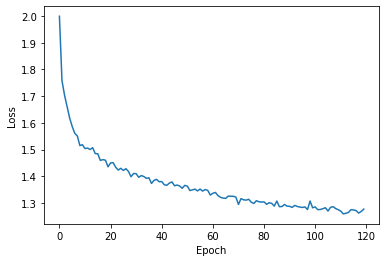

In [186]:

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [187]:
# image = load_image("/scratch/data/test2017/000000436789.jpg",size=img_size)
# image_batch = np.expand_dims(image, axis=0)
# # transfer_values1 = image_model_transfer.predict(image_batch)
# # transfer_values2 = capsule_model.predict(image_batch)
# # print(transfer_values1.shape)
# # print(transfer_values2.shape)
# transfer_values=np.concatenate([image_model_transfer.predict(image_batch),capsule_model.predict(image_batch)],1)
# print(transfer_values.shape)

In [188]:
# image_batch.shape

In [189]:
# print(K.min(transfer_values1))
# print(K.max(transfer_values1))
# print(K.min(transfer_values2))
# print(K.max(transfer_values2))

In [231]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

/home/javanmardis/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [232]:
# init_op = tf.global_variables_initializer()

# with tf.Session() as sess:
#      sess.run(tf.global_variables_initializer())
# tf.initialize_all_variables().run()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [152]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values1 = image_model_transfer.predict(image_batch)
    transfer_values2 = capsule_model.predict(image_batch)
    transfer_values=np.concatenate([transfer_values1,transfer_values2],1)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
#     plt.imshow(image)
#     plt.show()
    
#     # Print the predicted caption.
#     print("Predicted caption:")
#     print(output_text)

    return output_text

In [155]:
generate_caption("/scratch/shima/data/train2017/000000436078.jpg")


' a man is riding a skateboard on the beach eeee'

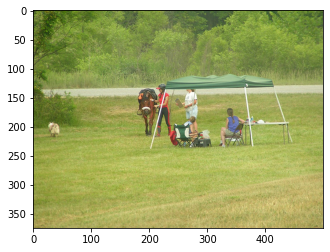

In [154]:
img2 = load_image("/scratch/shima/data/train2017/000000436078.jpg")
plt.imshow(img2)
plt.show()

In [118]:
def generate_caption_coco(idx, train=True):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_test[idx]
        captions = captions_test[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    output_text=generate_caption(image_path=path)
  

    # Print the true captions from the data-set.
#     print("True captions:")
#     for caption in captions:
#         print(caption)
        
    return output_text,captions

['Several plates of food are set on a table.', 'a plate of broccoli on a table next to some other plates of food ', 'A picture of a bunch food sitting on a table.', 'Several different types of foods on various plates on a table.', 'A bowl of broccoli, noodles and other various foods.']


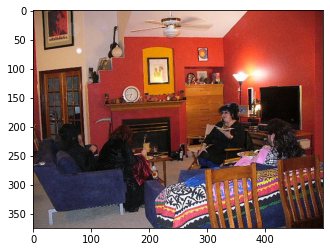

In [126]:
[Predicted_caption,True_captions]=generate_caption_coco(idx=551, train=False)
print(True_captions)
show_image(idx=551, train=True)

['A woman holding a Hello Kitty phone on her hands.', 'A woman holds up her phone in front of her face.', 'A woman in white shirt holding up a cellphone.', 'A woman checking her cell phone with a hello kitty case.', 'The Asian girl is holding her Miss Kitty phone']
 a man in a suit and glasses takes a picture eeee


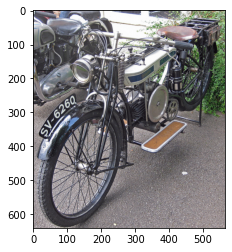

In [140]:
[Predicted_caption,True_captions]=generate_caption_coco(idx=11, train=False)
print(True_captions)
print(Predicted_caption)
# show_image(idx=11, train=True)


In [141]:
print(Predicted_caption)

 a man in a suit and glasses takes a picture eeee


In [142]:
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
chencherry = SmoothingFunction()

for idxx in range(len(filenames_val)):
    [Predicted_caption,True_captions]=generate_caption_coco(idx=idxx, train=False)
    candidate=Predicted_caption.split()
    reference=[]
    for caption in True_captions:
        reference.append(caption.split())

#     print('Cumulative bleu-1: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4))
#     print('Cumulative bleu-2: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4))
#     print('Cumulative bleu=3: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4))
#     print('Cumulative bleu-4: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4))

KeyboardInterrupt: 

In [ ]:
def my_lcs(string, sub):
    """
    Calculates longest common subsequence for a pair of tokenized strings
    :param string : list of str : tokens from a string split using whitespace
    :param sub : list of str : shorter string, also split using whitespace
    :returns: length (list of int): length of the longest common subsequence between the two strings

    Note: my_lcs only gives length of the longest common subsequence, not the actual LCS
    """
    if(len(string)< len(sub)):
        sub, string = string, sub

    lengths = [[0 for i in range(0,len(sub)+1)] for j in range(0,len(string)+1)]

    for j in range(1,len(sub)+1):
        for i in range(1,len(string)+1):
            if(string[i-1] == sub[j-1]):
                lengths[i][j] = lengths[i-1][j-1] + 1
            else:
                lengths[i][j] = max(lengths[i-1][j] , lengths[i][j-1])

    return lengths[len(string)][len(sub)]

In [ ]:
    def calc_score(candidate, refs):
        """
        Compute ROUGE-L score given one candidate and references for an image
        :param candidate: str : candidate sentence to be evaluated
        :param refs: list of str : COCO reference sentences for the particular image to be evaluated
        :returns score: int (ROUGE-L score for the candidate evaluated against references)
        """
        beta=1.2
#         assert(len(candidate)==1)	
#         assert(len(refs)>0)         
        prec = []
        rec = []

        # split into tokens
        token_c = candidate.split(" ")
        for reference in refs:
            # split into tokens
            token_r = reference.split(" ")
            # compute the longest common subsequence
            lcs = my_lcs(token_r, token_c)
            prec.append(lcs/float(len(token_c)))
            rec.append(lcs/float(len(token_r)))

        prec_max = max(prec)
        rec_max = max(rec)

        if(prec_max!=0 and rec_max !=0):
            score = ((1 + beta**2)*prec_max*rec_max)/float(rec_max + beta**2*prec_max)
        else:
            score = 0.0
        return score


In [ ]:
import nltk
from prettytable import PrettyTable
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

nltk.download('wordnet')
chencherry = SmoothingFunction()

# for idxx in range(len(filenames_val)):
dat_dtype = {
        'names' : ('idx', 'BLEU_1','BLEU_2','BLEU_3','BLEU_4','ROUGE','METEOR'),
        'formats' : ('i', 'f','f','f','f','f','f')}
dat = np.zeros(len(filenames_val), dat_dtype)
# dat = np.zeros(1000, dat_dtype)
x = PrettyTable(dat.dtype.names)
for idxx in range(len(filenames_val)):
# for idxx in range(1000):
    candidate=[]
    reference=[]
    [Predicted_caption,True_captions]=generate_caption_coco(idx=idxx, train=False)
    candidate=Predicted_caption.split()
    for caption in True_captions:
        reference.append(caption.split())
    dat['idx'][idxx] = idxx
    dat['BLEU_1'][idxx] = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    dat['BLEU_2'][idxx] = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4)
    dat['BLEU_3'][idxx] = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4)
    dat['BLEU_4'][idxx] = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)    
    dat['ROUGE'][idxx] = calc_score(Predicted_caption, True_captions)
    dat['METEOR'][idxx] = round(meteor_score(True_captions,Predicted_caption),4)
    
np.save('results',dat)
# for row in dat:
#     x.add_row(row)

# print(x)




In [ ]:
# from prettytable import PrettyTable
# dat2_dtype = {
#         'names' : ('BLEU_1','BLEU_2','BLEU_3','BLEU_4','ROUGE','METEOR'),
#         'formats' : ('f','f','f','f','f','f')}
# dat2 = np.zeros(1, dat2_dtype)
# x2 = PrettyTable(dat2.dtype.names)

# dat2['BLEU_1']=np.mean(dat['BLEU_1'])
# dat2['BLEU_2']=np.mean(dat['BLEU_2'])
# dat2['BLEU_3']=np.mean(dat['BLEU_3'])
# dat2['BLEU_4']=np.mean(dat['BLEU_4'])
# dat2['ROUGE']=np.mean(dat['ROUGE'])
# dat2['METEOR']=np.mean(dat['METEOR'])

# for row in dat2:
#     x2.add_row(row)
# print(x2)
# # print(dat2)
# np.save('dat_VGG',dat2)
# data = np.load('dat_VGG.npy')
# # print the array
# print(data)


In [ ]:
np.min(dat['BLEU_2'])

In [335]:
dat=np.load('results1.npy')

In [364]:
from prettytable import PrettyTable
dat2_dtype = {
        'names' : ('BLEU_1','BLEU_2','BLEU_3','BLEU_4','ROUGE','METEOR'),
        'formats' : ('f','f','f','f','f','f')}
dat2 = np.ones(4, dat2_dtype)
x2 = PrettyTable(dat2.dtype.names)

dat2['BLEU_1'][1]=np.mean(dat['BLEU_1'])
dat2['BLEU_2'][1]=np.mean(dat['BLEU_2'])
dat2['BLEU_3'][1]=np.mean(dat['BLEU_3'])
dat2['BLEU_4'][1]=np.mean(dat['BLEU_4'])
dat2['ROUGE'][1]=np.mean(dat['ROUGE'])
dat2['METEOR'][1]=np.mean(dat['METEOR'])
dat2['BLEU_1'][0]=np.max(dat['BLEU_1'])
dat2['BLEU_2'][0]=np.max(dat['BLEU_2'])
dat2['BLEU_3'][0]=np.max(dat['BLEU_3'])
dat2['BLEU_4'][0]=np.max(dat['BLEU_4'])
dat2['ROUGE'][0]=np.max(dat['ROUGE'])
dat2['METEOR'][0]=np.max(dat['METEOR'])
dat2['BLEU_1'][2]=np.min(dat['BLEU_1'])
dat2['BLEU_2'][2]=np.min(dat['BLEU_2'])
dat2['BLEU_3'][2]=np.min(dat['BLEU_3'])
dat2['BLEU_4'][2]=np.min(dat['BLEU_4'])
dat2['ROUGE'][2]=np.min(dat['ROUGE'])
dat2['METEOR'][2]=np.min(dat['METEOR'])
dat2['BLEU_1'][3]=np.mean(dat2['BLEU_1'])
dat2['BLEU_2'][3]=np.mean(dat2['BLEU_2'])
dat2['BLEU_3'][3]=np.mean(dat2['BLEU_3'])
dat2['BLEU_4'][3]=np.mean(dat2['BLEU_4'])
dat2['ROUGE'][3]=np.mean(dat2['ROUGE'])
dat2['METEOR'][3]=np.mean(dat2['METEOR'])
for row in dat2:
    x2.add_row(row)
print(x2)
# print(dat2)
np.save('dat_VGG',dat2)
# data = np.load('dat_VGG.npy')
# # print the array
# print(data)


+------------+------------+------------+------------+------------+------------+
|   BLEU_1   |   BLEU_2   |   BLEU_3   |   BLEU_4   |   ROUGE    |   METEOR   |
+------------+------------+------------+------------+------------+------------+
| 0.90909094 | 0.8819171  | 0.87476194 |  0.86334   | 0.9070632  |   0.9867   |
| 0.42273086 | 0.29997915 | 0.2730003  | 0.24673967 | 0.28042555 | 0.26933092 |
|    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |
| 0.5829555  | 0.54547405 | 0.5369406  | 0.52751994 | 0.5468722  | 0.56400776 |
+------------+------------+------------+------------+------------+------------+


In [363]:
np.mean(dat2['BLEU_1'])

0.4439406

In [319]:
np.load('dat_VGG.npy')

array([(0.90909094, 0.2815801, 0.26470336, 0.2411132, 0.2598086, 0.23248701)],
      dtype=[('BLEU_1', '<f4'), ('BLEU_2', '<f4'), ('BLEU_3', '<f4'), ('BLEU_4', '<f4'), ('ROUGE', '<f4'), ('METEOR', '<f4')])

In [ ]:
candidate=['a',
 'plane',
 'flying',
 'in',
 'the',
 'sky',
 'with',
 'a',
 'lot',
 'of',
 'smoke',
 'eeee']
reference=[['A', 'big', 'airplane', 'flying', 'in', 'the', 'big', 'blue', 'sky'],
 ['Large,', 'two', 'decked,', 'four', 'engined', 'airliner', 'in', 'flight.'],
 ['An', 'AirFrance', 'jet', 'airplane', 'flying', 'in', 'the', 'sky'],
 ['A', 'big', 'plane', 'with', 'AirFrance', 'on', 'the', 'side', 'of', 'it.'],
 ['An', 'Air', 'France', 'air', 'plane', 'in', 'mid', 'flight.']]


In [ ]:
reference=[]
for caption in True_captions:
    reference.append(caption.split())
reference
    

# EVALUATE Bleu-1,2,3,4 Metric

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
# score=sentence_bleu(reference,candidate)
chencherry = SmoothingFunction()
print('Cumulative bleu-1: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4))
print('Cumulative bleu-2: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4))
print('Cumulative bleu=3: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4))
print('Cumulative bleu-4: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4))

In [ ]:
True_captions[0]


# METEOR

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
True_captions

In [ ]:
from nltk.translate.meteor_score import meteor_score
round(meteor_score(True_captions,Predicted_caption),4)

# ROUGE

In [ ]:
calc_score(Predicted_caption, True_captions)

# CIDEr

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
# print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
# print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
# print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
generate_caption_coco(idx=10, train=True)

In [ ]:
generate_caption_coco(idx=1, train=False)

## Question



* Train the model for more epochs. Does it improve the quality of the generated captions?
* Try another architecture for the Recurrent Neural Network, e.g. change the number of GRU layers, their internal state-size, the embedding-size, etc. Can you improve the quality of the generated captions?
* Use another transfer-layer from the VGG16-model, for example the flattened output of the last convolutional layer.
* Try adding more dense-layers to the mapping between the transfer-values and the initial-state in the decoder.
* When generating captions, instead of using `np.argmax()` to sample the next integer-token, could you sample the decoder's output as if it was a probability distribution instead? Note that the decoder's output is not softmax-limited so you have to do that first to turn it into a probability-distribution.
* Can you generate multiple sequences by doing this sampling? Can you find a way to select the best of these different sequences?
* Connect the image-model directly to the decoder so you can fine-tune the weights of the image-model. See Tutorial #10 on Fine-Tuning.
* Can you train a Machine Translation model from Tutorial #21 and then connect its decoder to a pre-trained image-model to make an image captioning model? Perhaps you need an intermediate fully-connected layer that you will train.
* Can you measure the quality of the generated captions using some mathematical formula?
* Modify the decoder so it also returns the states of the GRU-units. Then change `generate_caption()` so it only inputs and outputs one integer-token in each iteration. You need to get the GRU-states out of `decoder_model.predict()` and feed them back in next time you call it. Now you compute less in each iteration, but there is still a lot of overhead, so it may not be much faster when using a GPU?
* Explain to a friend how the program works.